# Differential expression & cluster annotation  

## Introduction

Now that we've assigned cells into clusters, we'd like to understand what makes each cluster different from other cells in the dataset, or to annotate clusters according to their cell types (as has been previously done for this dataset).  

There are several approaches to this task:  

* Look for upregulation of marker genes for cell types of interest (compared to the rest of the dataset)  
* Compare the complete gene expression profiles between groups  
* Use automated methods to compare cells of interest to databases of cell type expression profiles to combine clustering and annotation  

Automated methods are a promising advance, but are not yet able to replace careful human curation. 

For well-defined cell types, we expect marker genes to show large differences in expression between the cell type of interest and the rest of the dataset, allowing us to use simple methods. We'll focus on this approach for this workshop, while building intuition that is broadly applicable to other approaches.

## Load data

### Important note! For differential expression, we need to use the _raw_ values stored in `adata.raw`.

With differential expression, we want to account for both the center and spread of the expression in each group. Recall that when we normalized our values, we standardized the distribution of each gene across cells to be centered at 0 and scaled with variance 1. So, when calculating differential expression, we should use the raw values (post-QC, pre-normalization). We saved these in `adata.raw` earlier on. 

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

adata = sc.read('../data/brain_clusters.h5ad')
raw = pd.DataFrame(data=adata.raw.X, index=adata.raw.obs_names, columns=adata.raw.var_names)

## Comparing distributions

Differential expression algorithms represent various approaches to comparing the distribution of gene expression in one group versus another group. Unlike bulk RNA-seq, we generally have a large number of samples (i.e. cells) for each group we are comparing in single-cell experiments. Thus, we can take advantage of the whole distribution of expression values in each group to identify differences between groups rather than only comparing estimates of mean-expression as is standard for bulk RNASeq. 

### Building intuition

Let's revisit some foundational statistics to build some intuition. 

In this example, we have a cluster of interest, and we want to determine if they are astrocytes. Let's start by plotting the distibution of a marker gene's expression in the cluster compared to the rest of the dataset.

In [3]:
astrocyte_marker = 'Gja1' # define genes of interest
housekeeping = 'Chmp2a' 

cluster2 = raw[adata.obs['louvain'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata.obs['louvain'] != '2'] # All other cells

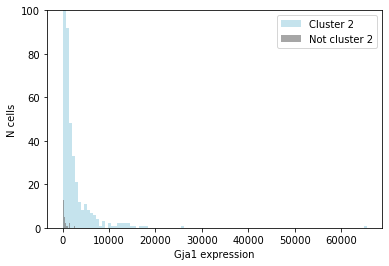

In [31]:
cluster2_marker_exp = cluster2[astrocyte_marker] 
plt.hist(cluster2_marker_exp.values, bins=100, color='lightblue', alpha=0.7, label='Cluster 2') # Plot distribution

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]
plt.hist(not_cluster2_marker_exp, bins=100, color='gray', alpha=0.7, label='Not cluster 2')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%astrocyte_marker) # label our axes
plt.ylabel('N cells')
plt.legend()

Just by eyeballing the two distributions, we can see that cells in this cluster express more of the marker gene than other cells in the dataset. However, we also see that these distributions overlap: some cells in the cluster don't express the gene at all, and some cells outside the cluster express it relatively highly. 

So, how do we decide whether this cluster is actually "differentially expressing" our marker gene? 

Because we expect the differences in expression to be relatively large for marker genes, we can use straightforward hypothesis testing methods to ask for the probability (p-value) that we would observe this level of differential expression if all these cells were, in fact, the same population (i.e., if the null hypothesis were true).

In [26]:
from scipy.stats import ttest_ind

ttest = ttest_ind(cluster2_marker_exp, 
          not_cluster2_marker_exp, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

Ttest_indResult(statistic=10.456174419645631, pvalue=2.5212453816250427e-23)


## Exercise: interpreting differential expression

Think - pair - share:

1 - What is one piece of information that this result tells you?  
2 - What is one piece of information you would like to know, but that the p-value doesn't tell you?  
3 - Based on these results, do you think this cluster represents astrocytes? Why or why not? 

<details><summary><h3>Solution</h3></summary>  
1 - This result tells you that we would be very surprised if these two populations had no true difference in mean expression, given the observed sample.<br><br>
2 - A t-test compares our data to the null hypothesis that the means of two distributions are **equal**. This accounts for the mean, standard deviation, and sample size of the two distributions. However, a p-value alone does not tell us anything about the *magnitude* of that difference: with large N, even very small (and biologically meaningless) differences in expression values can still return very "statistically significant" p-values. <br><br>  
3 - This has several tricky questions embedded in it:  <br>
* What constitutes a cell type? With what granularity? (E.g., lymphocytes > T cells > CD4+ T cells)  <br>
* How does cell state interact with cell type? (E.g., when annotating in/activated T cells)  <br>
Notably, although many cells in this cluster express the marker gene, there are many that don't. We should be careful before assuming that a cluster == a cell type!
</details>

## Exercise
Choose two subsets of the data (remember to use the raw values!). Plot the distribution of your favorite gene, and run the same t-test. Are the results as-expected? 

<details><summary><h3>Hints</h3></summary>
1 - To remind yourself of the available metadata, run <code>print(adata)</code>  <br>
2 - To subset the raw values based on metadata, use the following pattern:<br>  
    <code>variable = raw[ adata.obs[field] == value ]</code><br>
3 - To check if a gene is in this dataset, use <code>print('Gene1' in raw.columns.values)</code> (pay attention to the gene name casing! :)

## Working with the whole dataset  

Scanpy has a very useful function for repeating this process of subsetting the dataset to one group and comparing it to the rest of the dataset. It then returns the genes that are most differentially expressed between that group and all others. Let's look at the genes that are most cell-type specific. 

/usr/local/anaconda3/envs/sfn-workshop/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/usr/local/anaconda3/envs/sfn-workshop/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: invalid value encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/usr/local/anaconda3/envs/sfn-workshop/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


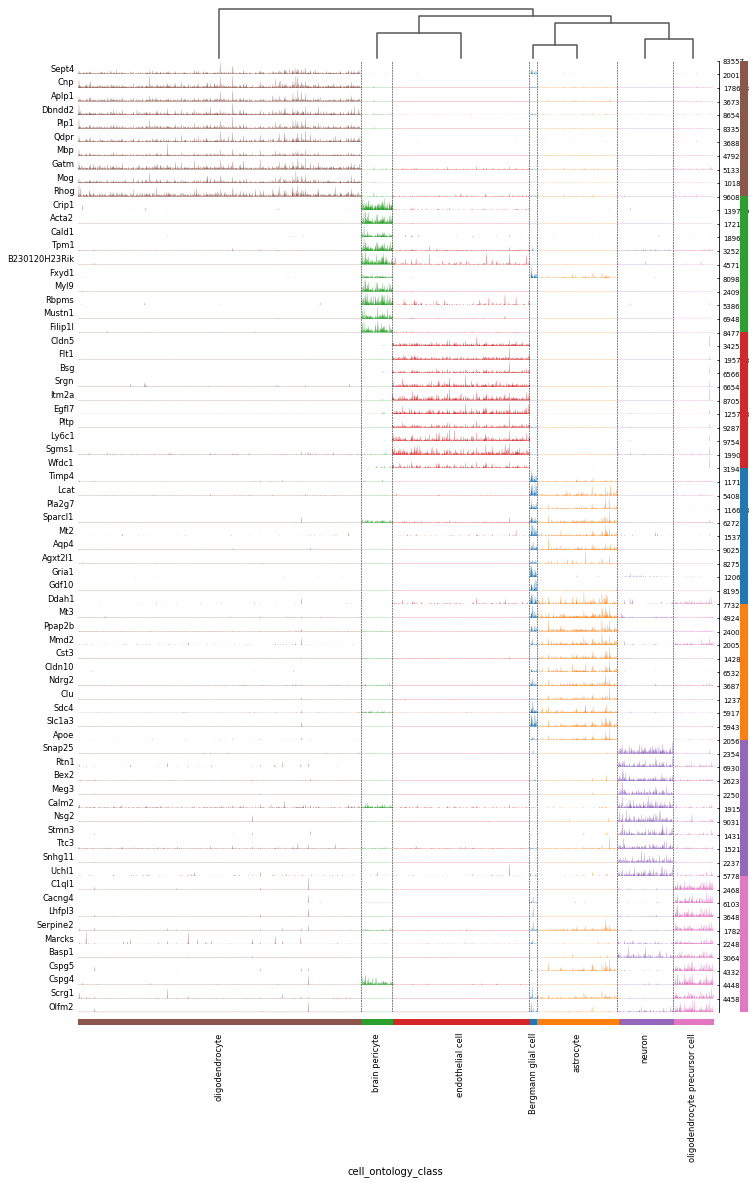

In [46]:
sc.tl.rank_genes_groups(adata, groupby='cell_ontology_class', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='cell_ontology_class') # plot the result

## Exercise

Repeat this process for the `louvain` cluster assignments. How closely do these overlap? Does this jive with the results from our Rand Index assessment of cluster labels?

<details><summary><h3>Solution</h3></summary>
<code>sc.tl.rank_genes_groups(adata, groupby='louvain', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='louvain') # plot the result</code>